# 1. Recurrent Neural Networks (RNNs)

# 1-1. RNN

In [ ]:
# set layer parameters
input_size  =  9 # number of features to extract (e.g., number of data channels)
hidden_size = 16 # number of units in the hidden state
num_layers  =  1 # number of vertical stacks of hidden layers (note: only the final layer gives an output)
actfun      = 'tanh'
bias        = True

# create an RNN instance
rnn = nn.RNN(input_size,hidden_size,num_layers,nonlinearity=actfun,bias=bias)
print(rnn)

In [ ]:
# check out the source code for more detailed info about this class
??nn.RNN

In [ ]:
# set data parameters
seqlength = 5
batchsize = 2

# create some data
X = torch.rand(seqlength,batchsize,input_size)

# create a hidden layer (typically initialized as zeros)
hidden = torch.zeros(num_layers,batchsize,hidden_size)


# run some data through the model and show the output sizes
y,h = rnn(X,hidden)
print(f' Input shape: {list(X.shape)}')
print(f'Hidden shape: {list(h.shape)}')
print(f'Output shape: {list(y.shape)}')

In [ ]:
## Default hidden state is all zeros if nothing specified:
y,h1 = rnn(X,hidden)
print(h1), print('\n\n')

y,h2 = rnn(X)
print(h2), print('\n\n')

# they're the same! (meaning default=zeros)
print(h1-h2)

In [ ]:
# Check out the learned parameters and their sizes
for p in rnn.named_parameters():
  if 'weight' in p[0]:
    print(f'{p[0]} has size {list(p[1].shape)}')

In [ ]:
class RNNnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # store parameters
    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self,x):
    
    print(f'Input: {list(x.shape)}')
    
    # initialize hidden state for first input
    hidden = torch.zeros(self.num_layers,batchsize,self.num_hidden)
    print(f'Hidden: {list(hidden.shape)}')

    # run through the RNN layer
    y,hidden = self.rnn(x,hidden)
    print(f'RNN-out: {list(y.shape)}')
    print(f'RNN-hidden: {list(hidden.shape)}')
    
    # pass the RNN output through the linear output layer
    o = self.out(y)
    print(f'Output: {list(o.shape)}')

    return o,hidden

In [ ]:
# create an instance of the model and inspect
net = RNNnet(input_size,hidden_size,num_layers)
print(net), print(' ')

# and check out all learnable parameters
for p in net.named_parameters():
  print(f'{p[0]} has size {list(p[1].shape)}')

In [ ]:
# test the model with some data
# create some data
X = torch.rand(seqlength,batchsize,input_size)
y = torch.rand(seqlength,batchsize,1)
yHat,h = net(X)

# try a loss function
lossfun = nn.MSELoss()
lossfun(yHat,y)

In [ ]:
# [2]
# import the data
N = 50

data = torch.zeros(N)

for i in range(N):
  data[i] = torch.rand(1) * (-1)**i

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

In [ ]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x):
    
    # run through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden

In [ ]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  5 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  =  9 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet(input_size,num_hidden,num_layers)

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

In [ ]:
# test the model with some data
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

In [ ]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

    # also get sign accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*(truesign==predsign)
    segacc.append(accuracy)
  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)
  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

In [ ]:
truesign

In [ ]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

In [ ]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


## compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

In [ ]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

In [ ]:
# Create new data WITH FLIPPED SIGNS!
newdata = torch.zeros(N)
for i in range(N):
  newdata[i] = torch.rand(1) * (-1)**(i+1)

In [ ]:
## now test the network!
# note: no learning here!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

In [ ]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()

In [ ]:
# [] GRU & LSTM
# set layer parameters
input_size  =  9 # number of features to extract (e.g., number of data channels)
hidden_size = 16 # number of units in the hidden state
num_layers  =  2 # number of vertical stacks of hidden layers (note: only the final layer gives an output)

# create an LSTM instance
lstm = nn.LSTM(input_size,hidden_size,num_layers)
lstm

In [ ]:
# check out the source code for more detailed info about this class
??nn.LSTM

In [ ]:
# set data parameters
seqlength = 5
batchsize = 2

# create some data
X = torch.rand(seqlength,batchsize,input_size)

# create initial hidden states (typically initialized as zeros)
H = torch.zeros(num_layers,batchsize,hidden_size)
C = torch.zeros(num_layers,batchsize,hidden_size)

# the input is actually a tuple of (hidden,cell)
hiddeninputs = (H,C)

# run some data through the model and show the output sizes
y,h = lstm(X,hiddeninputs)
print(f' Input shape: {list(X.shape)}')
print(f'Hidden shape: {list(h[0].shape)}')
print(f'  Cell shape: {list(h[1].shape)}')
print(f'Output shape: {list(y.shape)}')

In [ ]:
# Check out the learned parameters and their sizes
for p in lstm.named_parameters():
  if 'weight' in p[0]:
    print(f'{p[0]} has size {list(p[1].shape)}')

In [ ]:
class LSTMnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # store parameters
    self.input_size = input_size
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # RNN Layer (notation: LSTM \in RNN)
    self.lstm = nn.LSTM(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self,x):
    
    print(f'Input: {list(x.shape)}')

    # run through the RNN layer
    y,hidden = self.lstm(x)
    print(f'RNN-out: {list(y.shape)}')
    print(f'RNN-hidden: {list(hidden[0].shape)}')
    print(f'RNN-cell: {list(hidden[1].shape)}')
    
    # pass the RNN output through the linear output layer
    o = self.out(y)
    print(f'Output: {list(o.shape)}')

    return o,hidden

In [ ]:
# create an instance of the model and inspect
net = LSTMnet(input_size,hidden_size,num_layers)
print(net), print(' ')

# and check out all learnable parameters
for p in net.named_parameters():
  print(f'{p[0]:>20} has size {list(p[1].shape)}')

In [ ]:
# test the model with some data
# create some data
X = torch.rand(seqlength,batchsize,input_size)
y = torch.rand(seqlength,batchsize,1)
yHat,h = net(X)


lossfun = nn.MSELoss()
lossfun(yHat,y)

In [ ]:
# GRU
# create a GRU instance
gru = nn.GRU(input_size,hidden_size,num_layers)
gru

In [ ]:
??nn.GRU

In [ ]:
# create some data and a hidden state
X = torch.rand(seqlength,batchsize,input_size)
H = torch.zeros(num_layers,batchsize,hidden_size)

# run some data through the model and show the output sizes
y,h = gru(X,H) # No cell states in GRU!
print(f' Input shape: {list(X.shape)}')
print(f'Hidden shape: {list(h.shape)}')
print(f'Output shape: {list(y.shape)}')

In [ ]:
# Check out the learned parameters and their sizes
for p in gru.named_parameters():
  print(f'{p[0]:>15} has size {list(p[1].shape)}')

In [ ]:
# [] Lorem Ipsum
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent molestie sapien auctor eleifend egestas. Fusce at purus sodales, viverra nunc quis, consequat augue. Vestibulum eget tempus lorem, et blandit dui. Suspendisse ac gravida odio. Maecenas consequat tristique mi, vitae rutrum lacus pulvinar vitae. Nunc ullamcorper nulla eu velit vehicula, vitae facilisis erat dignissim. Proin consectetur nec lacus ac pellentesque. Nulla purus ligula, commodo id tellus id, efficitur varius massa. Phasellus et volutpat felis, gravida imperdiet justo. Cras metus velit, aliquet et tristique sit amet, elementum ultrices dui. Nullam condimentum quis orci quis pretium. Mauris tincidunt ante nec ex tristique, a commodo quam eleifend. Nam convallis ultrices magna fringilla porta. Phasellus non lobortis nisi. Donec nec lectus ligula. Maecenas id purus at lectus auctor finibus sit amet et enim. Vivamus nibh urna, dapibus sed porta in, sodales vitae elit. Fusce sed facilisis elit, ut porta massa. Vivamus blandit congue erat eget rutrum. Nullam mollis, eros et laoreet euismod, nunc mi condimentum eros, mollis pretium mi orci in nibh. Pellentesque rhoncus justo et pretium tempor. Ut gravida egestas quam, sit amet sagittis tortor scelerisque in. Vestibulum sed odio urna. Donec semper quis erat quis laoreet. Ut malesuada volutpat sem ac luctus. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Praesent sed bibendum sapien, id imperdiet elit. Vestibulum erat lorem, finibus eu enim non, posuere tempus velit. Vestibulum a massa id orci interdum malesuada eu vel tellus. Proin tempus viverra scelerisque. Nullam suscipit laoreet nisl, id consequat sem porttitor et. Integer congue urna lacus, ac feugiat arcu tincidunt eget. Aliquam erat volutpat. Vivamus accumsan semper gravida. Mauris porta magna vitae semper hendrerit. Vestibulum urna nunc, faucibus sit amet auctor sed, scelerisque nec est. Nulla ut sagittis urna. Proin fermentum turpis non iaculis tincidunt. Maecenas scelerisque rutrum hendrerit. Sed fermentum vehicula molestie. Sed nec rutrum nisi. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Cras malesuada, magna in ornare pretium, leo tellus sodales tortor, sit amet fermentum nunc odio eu enim. Quisque placerat eros ornare nulla vulputate, at efficitur sem convallis. Sed libero risus, viverra a turpis a, sollicitudin feugiat neque. Fusce vitae erat commodo, consectetur lacus vel, sollicitudin lorem. Nunc sed risus arcu. Pellentesque nec eleifend risus, a fringilla odio. Sed auctor augue a rutrum maximus. Maecenas suscipit tellus sem, vitae suscipit nisl euismod a. Phasellus elementum sodales urna, ac fringilla mi malesuada id. Suspendisse sollicitudin rhoncus dolor ut consequat. Duis tincidunt quis neque nec tincidunt. Fusce vitae sagittis nulla. Suspendisse ac varius mauris. Maecenas dapibus posuere velit, nec pellentesque quam sagittis a. Nunc aliquet justo vitae justo pharetra consectetur. Nam porttitor at nisl sit amet ullamcorper. Sed rutrum, nulla ac porttitor pulvinar, nisi leo hendrerit magna, non luctus nibh risus eget est. Quisque pulvinar rutrum vehicula. Ut tempor placerat sollicitudin. Etiam pharetra sit amet nulla at fringilla. Pellentesque feugiat odio ligula, ac ullamcorper leo vulputate a. Vestibulum placerat interdum arcu, sit amet ullamcorper ipsum finibus sed. Aliquam erat volutpat. Nam tincidunt, augue eu eleifend dictum, tellus sem blandit sem, et pulvinar ex purus sed leo. Nullam ultricies tincidunt sem, imperdiet condimentum ex porttitor at. Nunc id lacus sit amet nibh elementum dignissim. Nam facilisis tincidunt tincidunt. Suspendisse in mauris vel dui imperdiet facilisis. Aenean eu neque tortor. Cras sit amet mi nibh. Mauris sit amet feugiat nulla. Nam ac leo ipsum. Vestibulum id enim sit amet est pharetra consectetur. Vestibulum et lacus sed ipsum placerat blandit vitae quis nisl. Curabitur lacus est, euismod non accumsan sed, accumsan nec lectus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Maecenas ultrices eros in erat molestie interdum. Nunc et tellus orci. Maecenas et magna ornare mauris sodales malesuada. Duis iaculis ipsum non laoreet porta. Aenean vitae purus tempor, porttitor arcu id, bibendum enim. Aliquam faucibus congue eros, eget feugiat risus venenatis a. Duis malesuada, sem eu mattis placerat, velit lectus varius tellus, eget placerat nibh quam non turpis. Donec auctor pellentesque odio, nec pulvinar nisi fermentum eget. Mauris eget eleifend metus. Mauris venenatis arcu semper erat facilisis, malesuada viverra tortor imperdiet. Nunc ut quam sit amet ex varius euismod. Mauris eleifend lectus venenatis risus mattis consequat. Nulla a eros non erat egestas consequat nec volutpat neque. In diam nulla, mollis ut semper nec, vulputate luctus odio. Morbi ac elementum quam, ut vestibulum sem. Ut tincidunt sapien ac fermentum ullamcorper. Cras convallis tortor quis malesuada dignissim. Suspendisse rutrum cursus diam, in consequat nisi vulputate sit amet. Nunc euismod consectetur libero eu pulvinar. Ut finibus scelerisque lectus vel auctor. Vivamus congue non sem et tincidunt. Vestibulum vehicula erat sed nisi mattis aliquet. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Etiam pulvinar tortor enim, vel blandit mauris sodales quis. Ut bibendum dui non posuere pellentesque. Phasellus metus diam, blandit accumsan porta a, pharetra nec nulla. Nam pulvinar, lacus et ornare luctus, magna orci tincidunt lorem, porttitor tincidunt enim mi a ligula. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Etiam quis mi porta, mattis velit vel, rhoncus nisi. Etiam lobortis placerat lacus.'.lower()
# generated at https://www.lipsum.com/

print(text)

In [ ]:
# get all the unique characters
uniquecharacters = set(text)
uniquecharacters

In [ ]:
# look-up tables to convert characters to indices and vice-versa
number2letter = dict(enumerate(uniquecharacters))
letter2number = { l:i for i,l in number2letter.items() }

letter2number#['e']
number2letter

In [ ]:
# convert the text from characters into numbers

# note the inputs to zeros()
data = torch.zeros( (len(text),1), dtype=torch.int64, device=device)
for i,ch in enumerate(text):
  data[i] = letter2number[ch]


# let's see the data!
print(data)
plt.plot(data.cpu().numpy(),'k.')
plt.xlabel('Character index')
plt.ylabel('Character label');

In [ ]:
class lstmnet(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers):
    super().__init__()

    # embedding layer
    self.embedding = nn.Embedding(input_size,input_size)

    # LSTM layer
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers)

    # linear output layer
    self.out = nn.Linear(hidden_size,output_size)


  def forward(self,x,h):

    # embedding layer
    embedding = self.embedding(x)

    # run through the RNN layer
    y,h = self.lstm(embedding,h)

    # and the output (linear) layer
    y = self.out(y)

    return y,(h[0].detach(),h[1].detach()) # just the numerical values for h

In [ ]:
# meta-parameters
hidden_size = 512   # size of hidden state
seqlength   = 80    # length of sequence
num_layers  = 3     # number of stacked hidden layers
epochs      = 10    # training epochs

In [ ]:
# model instance
lstm = lstmnet(len(uniquecharacters),len(uniquecharacters), hidden_size, num_layers).to(device)

# loss function and optimizer
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=.001)

In [ ]:
# visualize the randomly initialized embeddings matrix
I = next(lstm.embedding.named_parameters())
plt.imshow(I[1].cpu().detach());

In [ ]:
losses = np.zeros(epochs)


# loop over epochs
for epochi in range(epochs):

  # initialize loss for this epoch, and hidden state
  txtloss = 0
  hidden_state = None

  # loop through the entire text character-wise
  for txtloc in range(0,len(text)-seqlength):

    # get input and target (shifted version of input)
    x = data[txtloc   : txtloc+seqlength  ]
    y = data[txtloc+1 : txtloc+seqlength+1]

    # forward pass
    output, hidden_state = lstm(x,None)

    # compute loss
    loss = lossfun(torch.squeeze(output), torch.squeeze(y))
    txtloss += loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # average losses for this epoch (run through the entire text)
  losses[epochi] = txtloss/txtloc

In [ ]:
# check out the losses
plt.plot(losses,'s-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# reconstructing a character sequence from number sequence
t = ''
for l in x:
  t += number2letter[l.item()]

t

In [ ]:
# how many characters to generate?
lorem_length = 200

# random character from data to begin
x = torch.tensor(letter2number['x']).view(1,1).to(device)
lorem = number2letter[x.item()]

# initialize the hidden state
hidden_state = None


# generate the text!
for i in range(lorem_length):

  # push a letter though the LSTM
  output, hidden_state = lstm(x,hidden_state)

  # get the maximum output and replace input data
  index = torch.argmax(output).item()
  x[0][0] = index

  # append that output to the text
  lorem += number2letter[index]


## what's it say?!?!?!
lorem

In [ ]:
# plot hidden states
for i in range(num_layers):
  plt.plot(hidden_state[0][i,0,:].cpu().numpy(),'o');

In [ ]:
# visualize the learned embeddings matrix
I = next(lstm.embedding.named_parameters())
I = I[1].cpu().detach().numpy()
plt.imshow(I);

In [ ]:
# FYI, lots can be done with this matrix, e.g., PCA...
d,V = np.linalg.eig(I@I.T)

fig,axs = plt.subplots(1,2,figsize=(8,5))
axs[0].imshow(np.corrcoef(I),vmin=-.5,vmax=.5)
axs[0].set_title('Correlation of embeddings')
axs[0].set_xticks(range(len(letter2number.keys())))
axs[0].set_xticklabels(letter2number.keys())
axs[0].set_yticks(range(len(letter2number.keys())))
axs[0].set_yticklabels(letter2number.keys())

axs[1].plot(d,'s-')
axs[1].set_xlabel('Component')
axs[1].set_ylabel('Eigenvalue')
axs[1].set_title('Eigenspectrum of embeddings')

plt.tight_layout()
plt.show()

## 1-2. RNN

[Large Movie Review Dataset](https://ai.stanford.edu/%7Eamaas/data/sentiment/) for binary sentiment classification from Stanford.
- [imdb_reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews)

In [1]:
import pandas as pd
import glob

# Get the class names from the target directory
class_names_found = ['pos', 'neg']

# Construct a pandas DataFrame using `read()`
dict_train = []

for class_name in class_names_found:
    doc_lst = glob.glob(f"./datasets/aclImdb_v1/aclImdb/train/{class_name}/*.txt", recursive=True)
    for filename in doc_lst:
        with open(filename, 'r', errors='replace') as f:
            # Use `read()` instead of `readlines()`
            doc = f.read()
            dict_train.append({"text": doc, "label": class_name})

df_train = pd.DataFrame(dict_train)
df_train

,text,label
0,I don't understand why the other comments focu...,pos
1,The information contained in this movie is som...,pos
2,The premise of this anime series is about brea...,pos
3,"I watched the first series avidly, but wondere...",pos
4,"""GOOD TIMES,"" in my opinion, is a must-see CBS...",pos
...,...,...
24995,"First of all, I was expecting ""Caged Heat"" to ...",neg
24996,THIS IS NOT A CHILDREN'S MOVIE!!!<br /><br />T...,neg
24997,"Perhaps because I was so young, innocent and B...",neg
24998,By all the fawning people have been doing over...,neg


In [2]:
# Construct a pandas DataFrame using `read()`
dict_test = []

for class_name in class_names_found:
    doc_lst = glob.glob(f"./datasets/aclImdb_v1/aclImdb/test/{class_name}/*.txt", recursive=True)
    for filename in doc_lst:
        with open(filename, 'r', errors='replace') as f:
            # Use `read()` instead of `readlines()`
            doc = f.read()
            dict_test.append({"text": doc, "label": class_name})

df_test = pd.DataFrame(dict_test)
df_test

,text,label
0,I like both this version of DORIAN GRAY and th...,pos
1,"On the face of it, any teen comedy runs the ri...",pos
2,"""Icky Flix"" is an excellent starting point for...",pos
3,"I just saw this at SIFF, and I absolutely love...",pos
4,"The creative team of Jim Abrahams, David Zucke...",pos
...,...,...
24995,I am sitting here writing this review and the ...,neg
24996,I can't believe some of the scores this film i...,neg
24997,"I have just watched this ""latest"" version of M...",neg
24998,"Woa, talk about awful. Do not waste your time....",neg


In [3]:
df_train['label'] = df_train['label'].map({'neg': 0, 'pos': 1})
df_train

,text,label
0,I don't understand why the other comments focu...,1
1,The information contained in this movie is som...,1
2,The premise of this anime series is about brea...,1
3,"I watched the first series avidly, but wondere...",1
4,"""GOOD TIMES,"" in my opinion, is a must-see CBS...",1
...,...,...
24995,"First of all, I was expecting ""Caged Heat"" to ...",0
24996,THIS IS NOT A CHILDREN'S MOVIE!!!<br /><br />T...,0
24997,"Perhaps because I was so young, innocent and B...",0
24998,By all the fawning people have been doing over...,0


In [4]:
df_test['label'] = df_test['label'].map({'neg': 0, 'pos': 1})
df_test

,text,label
0,I like both this version of DORIAN GRAY and th...,1
1,"On the face of it, any teen comedy runs the ri...",1
2,"""Icky Flix"" is an excellent starting point for...",1
3,"I just saw this at SIFF, and I absolutely love...",1
4,"The creative team of Jim Abrahams, David Zucke...",1
...,...,...
24995,I am sitting here writing this review and the ...,0
24996,I can't believe some of the scores this film i...,0
24997,"I have just watched this ""latest"" version of M...",0
24998,"Woa, talk about awful. Do not waste your time....",0


## 7-1. Masking & Padding

**Masking** is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data. **Padding** is a special form of masking where the masked steps are at the start or the end of a sequence. Padding comes from the need to encode sequence data into contiguous batches. In order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences. The steps are as follows:

- Truncate and pad samples to a uniform length, for Individual samples of sequence data usually have different lengths.
- Mask some parts of the input data which are actually paddings and should be ignored before sent to the model.
- Re-pad the model outputs for the final output layer to get scores over the vocabulary space.

There are several approaches in PyTorch:
- Just pad the sequences and train the model without masking. It is computationally inefficient, but it does not lead to inaccurate representations. Need more logic to extract correct representations for sequences.
    - For RNN modules with only forward direction, pick up the hidden vector from `L`th step, instead of the last step, as a representation.
    - For bidirectional RNN modules, have to work with pre padding & post padding at once, and finally extract and concatenate the hidden vectors as above.
- Or perform **Sequence Packing**, creating a consistent-sized data structure, `PackedSequence`, composed of variable length sequences, with PyTorch utility functions.
    - Create a custom `Dataset` class because `TensorDataset` does not allow variable sequence lengths.
    - Pad sequences in custom `collate_fn` of `DataLoader` and also return original sequence lengths for used later in `pack_padded_sequence`.

PyTorch:

1. `torch.nn.utils.rnn.pad_sequence(sequences, batch_first=False, padding_value=0.0)`: Stacks a list of `Tensor`s along a new dimension and pads them to equal length. For example, if the input is a list of sequences with size `(L, *)` and `batch_first` is False, the output is of size `(B, T, *)`. `B` is batch size. It is equal to the number of elements in sequences. `T` is length of the longest sequence. `L` is length of the sequence. `*` is any number of trailing dimensions, including `None`. Only supports post padding.
   - Because of **Gradient Vanishing**, pre padding is recommended.
   - [Effects of Padding on LSTMs & CNNs](https://arxiv.org/abs/1903.07288)
2. `torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)`: Packs a `Tensor` containing padded sequences of variable length. All RNN modules in PyTorch accept packed sequences as inputs. If `enforce_sorted` is `True`, the input is expected to contain sequences sorted by length in a decreasing order. If `False`, the input will get sorted unconditionally.
3. `torch.nn.utils.rnn.pad_packed_sequence(sequence, batch_first=False, padding_value=0.0, total_length=None)`: Pads a packed batch of variable length sequences.
4. `torch.nn.utils.rnn.pack_sequence(sequences, enforce_sorted=True)`: Consecutive call of `pad_sequence` & `pack_padded_sequence`.

Keras:

5. `tf.keras.utils.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)`: Supports truncating and pre padding.
   - [Masking](https://www.tensorflow.org/guide/keras/understanding_masking_and_padding#masking) in TensorFlow

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
sequences_train = tokenizer.texts_to_sequences(df_train.text)
# filtered_sequence_train = list(filter(lambda x: (x != []), sequence_train))
sequences_test = tokenizer.texts_to_sequences(df_test.text)

# Get sequence lengths
train_lengths = [len(x) for x in sequences_train]
test_lengths = [len(x) for x in sequences_test]

word2idx = tokenizer.word_index
V = len(word2idx)
print("Found %s unique tokens." % V)

2024-07-22 01:59:05.569021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 01:59:05.576823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 01:59:05.586475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 01:59:05.586489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 01:59:05.592718: I tensorflow/core/platform/cpu_feature_gua

Found 88582 unique tokens.


In [258]:
# `pad_sequences()` from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print("Shape of Training Set Tensor:", data_train.shape)
print("Sample:", data_train[0])

Shape of Training Set Tensor: (25000, 2493)
Sample: [  0   0   0 ...  73 326 218]


In [259]:
# `pad_sequence()`
from torch.nn.utils.rnn import pad_sequence

# Convert list of lists to list of tensors
sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
data_train = pad_sequence(sequences=sequences_train_tensor, batch_first=True)
print("Shape of Training Set Tensor:", data_train.shape)
print("Sample:", data_train[0])

Shape of Training Set Tensor: torch.Size([25000, 2493])
Sample: tensor([ 10,  89, 388,  ...,   0,   0,   0])


In [261]:
# `pack_padded_sequence()`
from torch.nn.utils.rnn import pack_padded_sequence

train_lengths_tensor = torch.as_tensor(train_lengths)
packed_data_train = pack_padded_sequence(input=data_train, lengths=train_lengths_tensor, batch_first=True, enforce_sorted=False)
packed_data_train

PackedSequence(data=tensor([1012, 2737,  688,  ...,    3,    7,    7]), batch_sizes=tensor([25000, 25000, 25000,  ...,     1,     1,     1]), sorted_indices=tensor([ 5079,   329,  7842,  ..., 22795, 24523, 13597]), unsorted_indices=tensor([16274,  9240, 19451,  ..., 15842,  6124,  2493]))

In [262]:
# `pad_packed_sequence()`
from torch.nn.utils.rnn import pad_packed_sequence

unpacked_data_train, unpacked_train_lengths = pad_packed_sequence(sequence=packed_data_train, batch_first=True)
print("Shape of Training Set Tensor:", unpacked_data_train.shape)
print("Sample:", unpacked_data_train[0])

Shape of Training Set Tensor: torch.Size([25000, 2493])
Sample: tensor([ 10,  89, 388,  ...,   0,   0,   0])


In [265]:
# `pack_sequence()`
sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
packed_data_train = pack_sequence(sequences=sequences_train_tensor, enforce_sorted=False)
packed_data_train

PackedSequence(data=tensor([1012, 2737,  688,  ...,    3,    7,    7]), batch_sizes=tensor([25000, 25000, 25000,  ...,     1,     1,     1]), sorted_indices=tensor([ 5079,   329,  7842,  ..., 22795, 24523, 13597]), unsorted_indices=tensor([16274,  9240, 19451,  ..., 15842,  6124,  2493]))

In [136]:
# Custom pre padding for PyTorch
from torch import Tensor
from typing import Union, List

def pad_sequence_with_pos(
    sequences: Union[Tensor, List[Tensor]],
    batch_first: bool = False,
    padding_value: float = 0.0,
    pos: str = 'post',
) -> Tensor:

    if pos == 'post':
        padded_sequence = torch._C._nn.pad_sequence(sequences, batch_first, padding_value)
    elif pos == 'pre':
        sequences = tuple(map(lambda s: s.flip(0), sequences))
        padded_sequence = torch._C._nn.pad_sequence(sequences, batch_first, padding_value)
        _seq_dim = padded_sequence.dim()
        padded_sequence = padded_sequence.flip(-_seq_dim+batch_first)
    else:
        raise ValueError("pos should be either 'post' or 'pre', but got {}".format(pos))
    return padded_sequence

In [137]:
sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
data_train = pad_sequence_with_pos(sequences_train_tensor, batch_first=True, pos='pre')
print("Shape of Training Set Tensor:", data_train.shape)

Shape of Training Set Tensor: torch.Size([25000, 2493])


Handle sequence padding & packing with `Dataset` and `DataLoader`.

In [6]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Pad test set & turn label series to tensors
y_train = torch.tensor(df_train['label'].values)
y_test = torch.tensor(df_test['label'].values)

sequences_train_tensor = list(map(lambda x: torch.as_tensor(x), sequences_train))
data_train = pad_sequence(sequences_train_tensor, batch_first=True)
# sequences_train_tensor = torch.cat(sequences_train_tensor)
sequences_test_tensor = list(map(lambda x: torch.as_tensor(x), sequences_test))
data_test = pad_sequence(sequences_test_tensor, batch_first=True)

In [7]:
# sequence_lengths_train = torch.tensor([len(seq) for seq in sequences_train])
# sequence_lengths_test = torch.tensor([len(seq) for seq in sequences_test])
# print(sequence_lengths_train)
# print(sequence_lengths_test)

In [8]:
# `TensorDataset()`
# train_dataset = torch.utils.data.TensorDataset(data_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(data_test, y_test)
# train_dataset[0]

In [7]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, y):
        self.data = data
        self.y = y
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return (self.data[idx], self.y[idx])

train_dataset = CustomDataset(sequences_train_tensor, y_train)
train_dataset[0]

(tensor([   10,    89,   388,   135,     1,    82,   792,  1148,    20, 14896,
            26,    44,   112,    74,     3,    52,   218,    19,   281,     7,
             7,     1,   115,   170,     4,    11,    17,     6,     1,   484,
             2,     1,  2205,  4939, 13886,     2,  2326, 40830,    94,    32,
          1727,   695,  3866,   404,    21,  2043,  2103,   258,    28,   188,
           132,    65,   102,    23,    70,  1383,    12,   149,    94,    95,
            98,   326,   160,     7,     7,     1,   307,    10,   216,    13,
            20, 40831,     2,    66,  2567,    15,     1,  1866,   804,    35,
            12,    13,   431,    21,     3,   436,     1,   358,     4,  1866,
           405,     9,    50,  6259,     7,     7,     3,    52,  2178,    17,
          4201,    31,     1,  6985,   361,   600,   894,  1063,    25,   345,
             9,    10,   194,     9,    13,   250,     2,   218,     2,   287,
             3,   690,    30,   219,     3,   173,  

In [10]:
# train_dataset = CustomDataset(data_train, y_train)
# train_dataset[0]

In [8]:
test_dataset = CustomDataset(sequences_test_tensor, y_test)
test_dataset[0]

(tensor([   10,    37,   196,    11,   307,     4, 31688,  3833,     2,     1,
          2727,   307,   196,   758,     3,   114,   247,   399,     8,     1,
            62,    34,  3414,    53,     5,    25,    32,  8951,    16, 31688,
            11,     6,    21,     8,     1,   201,   271,     2,    12,     6,
            58,    61,  3290,    10,   259,    37,  4934,  9042,    14, 10303,
         37673,     2,   739,  7073,    14,  1331,     8,     1,  2727,   307,
            18, 11839, 59093,    14, 31688,     8,     1,   245,   307,     6,
            73,   125,   264,    10,   101,     2,   227,    50,  4269,    71,
         68102, 68103,     8,     1,  2727,   307,    10,   101, 59093,     6,
            50,   280,     5,     1, 14727, 31688,     8,     1,   127,    11,
             6,     3,    52,    49,  1251,     4,     1,   664,     9,    57,
          4190,    30,    16,   346,    14,   124,    60,    97,    21,    27,
           221,     8,     1,  2727,   307]),
 tenso

In [9]:
from torch.utils.data import Dataset, DataLoader

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    # print(xx, yy)

    x_lens = [len(x) for x in xx]
    y_lens = 1

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = torch.Tensor(yy)

    return xx_pad, yy_pad, x_lens, y_lens

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

In [10]:
# Iterate through the dataloader to display text and label
train_features, train_y, train_length, train_y_length = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(train_y)
print(f"Feature batch shape: {train_y.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
text = train_features[0].squeeze()
y = train_y[0].squeeze()
length = train_length[0]
y_len = train_y_length
print(f"Text: {text}")
print(f"y: {y}")
print(f"Length: {length}")
print(f"y Length: {y_len}")

Feature batch shape: torch.Size([32, 906])
tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])
Feature batch shape: torch.Size([32])
Text: tensor([   11,   120,   263,    53,    16,   218,  1981,    14,   699,    14,
            1,  2107,  1305,     9,     6,  5163,    14,   632,    18,     8,
        10134,     9,     6,  1047,  2479,    55,  1844,  1421,    42,   494,
            5,   358,  4199,  9141,    14,     3, 12761,     5,   718,    81,
           80,     3,  4974,  4957,    92,  4738,     5,  4363,   794,    20,
            1,  6927,  1844,  1421,   402,     7,     7,     9,    79,  8653,
           36,    32,   399,  6260,   497,   120, 10818,  1558,     1,  5421,
           31, 12468,  1183,    15,    91,  6927,     5,   350,  3071,    92,
            9, 12893,     1,  2279,   275,    45,    33,    67,  6779,     9,
           53,    16,     3,   114,  4333,   197,     1,   102,   

## 7-2. RNN

In [12]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
import torch.nn as nn

# Define the model
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.embed = nn.Embedding(self.V, self.D)
        # self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            # dropout=0.5,
            batch_first=True
        )
        self.dropout = nn.Dropout(p=0.5)
        # self.dense = nn.Linear(self.M, 256)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X, X_lengths):
        h_0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c_0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        out = self.embed(X)
        out = self.dropout(out)
        # print(out.shape)
        # (32, 999, 128)torch.Size([32, 698, 128])
        out = torch.nn.utils.rnn.pack_padded_sequence(out, X_lengths, batch_first=True, enforce_sorted=False)
        out, _ = self.rnn(out, (h_0, c_0))
        out, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        #print(out.shape)
        #torch.Size([698, 32, 256])
        # out = self.dense(out)
        # out = nn.functional.relu(out)
        out = self.dropout(out)
        out, _ = torch.max(out, 1)
        #print(out.shape)
        #torch.Size([698, 256])
        out = self.fc(out)
        #print(out.shape)
        #torch.Size([698, 1])
        return out

In [43]:
model = RNN(V+1, 128, 32, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(88583, 128)
  (rnn): LSTM(128, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [44]:
from datetime import datetime
import numpy as np

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t_0 = datetime.now()
        train_loss = []
        for inputs, targets, x_lens, y_lens in train_loader:
            # print("inputs.shape:", inputs.shape, "targets.shape", targets.shape)
            targets = targets.view(-1, 1).float()
            # Move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, x_lens)
            loss = criterion(outputs, targets)

            # Backward & optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss & test loss
        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets, x_lens, y_lens in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(inputs, x_lens)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t_0
        print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
    return train_losses, test_losses

train_losses, test_losses = batch_gd(model, criterion, optimizer, train_dataloader, test_dataloader, 10)

Epoch 1/10, Train Loss: 0.6777, Test Loss: 0.6514, Duration: 0:00:17.182787
Epoch 2/10, Train Loss: 0.5681, Test Loss: 0.5043, Duration: 0:00:16.965491
Epoch 3/10, Train Loss: 0.4337, Test Loss: 0.4188, Duration: 0:00:16.535316
Epoch 4/10, Train Loss: 0.3648, Test Loss: 0.3906, Duration: 0:00:16.793443
Epoch 5/10, Train Loss: 0.3233, Test Loss: 0.3696, Duration: 0:00:16.790974
Epoch 6/10, Train Loss: 0.2886, Test Loss: 0.3645, Duration: 0:00:16.974890
Epoch 7/10, Train Loss: 0.2699, Test Loss: 0.3594, Duration: 0:00:16.828900
Epoch 8/10, Train Loss: 0.2464, Test Loss: 0.3501, Duration: 0:00:16.804966
Epoch 9/10, Train Loss: 0.2295, Test Loss: 0.3548, Duration: 0:00:16.981852
Epoch 10/10, Train Loss: 0.2108, Test Loss: 0.3545, Duration: 0:00:16.733287


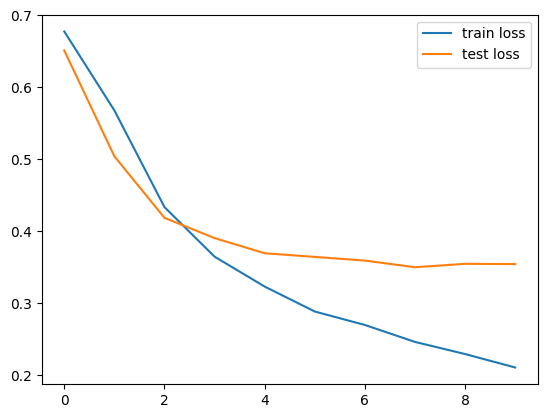

In [45]:
import matplotlib.pyplot as plt 

plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [46]:
# Accuracy
n_correct = 0.
n_total = 0.
for inputs, targets, x_lens, y_lens in train_dataloader:
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs, x_lens)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets, x_lens, y_lens in test_dataloader:
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs, x_lens)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9232, Test acc: 0.8516


# 2. GRU

# 3. LSTM